#Step 1: Import the necessary libraries

Here we will import the necessary libraries that will be used to build the k-NN model and this whole assignment.

In [ ]:
import os
import random
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Step 2: Load the dataset from Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
dataset_path = "/content/drive/MyDrive/animal_dataset"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Step 3: Define Constants & Lists

In [ ]:
CATEGORIES = ["cat", "dog", "panda"]
IMG_SIZE = 32
k_max = 10
TRAIN_DATA = []

# Step 4: Data Loading & Processing

Loading images...



Loading panda: 100%|██████████| 100/100 [00:01<00:00, 57.15it/s]


Total images loaded: 300


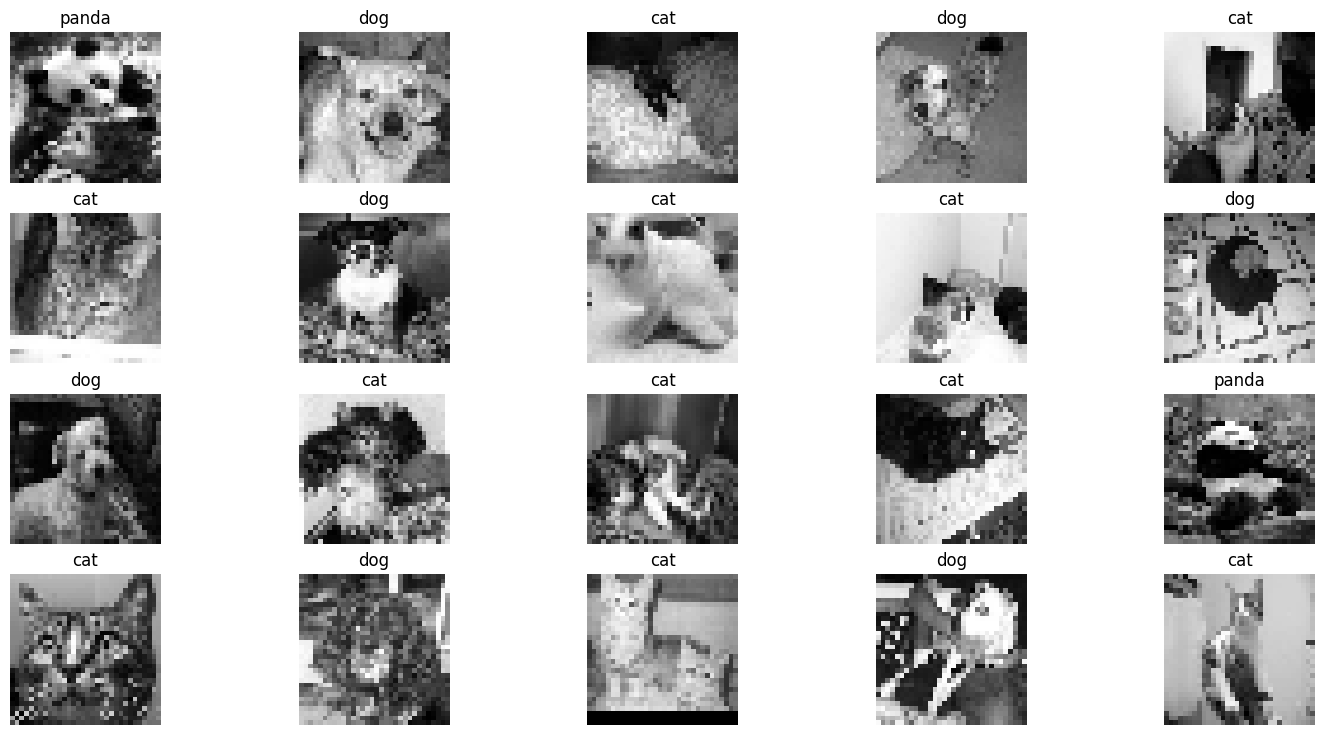

In [ ]:
print("Loading images...\n")

for category in CATEGORIES:
    folder = os.path.join(dataset_path, category)
    class_id = CATEGORIES.index(category)

    for img_name in tqdm(os.listdir(folder), desc=f"Loading {category}"):
        img_path = os.path.join(folder, img_name)
        img = cv.imread(img_path)

        if img is None:
            continue

        gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        gray = cv.resize(gray, (IMG_SIZE, IMG_SIZE))

        TRAIN_DATA.append([gray, class_id])

print("Total images loaded:", len(TRAIN_DATA))
random.shuffle(TRAIN_DATA)

plt.figure(figsize=(18, 9))
for i in range(20):
    plt.subplot(4, 5, i + 1)
    plt.imshow(TRAIN_DATA[i][0], cmap="gray")
    plt.title(CATEGORIES[TRAIN_DATA[i][1]])
    plt.axis("off")
plt.show()


# Step 5: Create Folds for Cross-Validation

In [ ]:
f0 = TRAIN_DATA[0:60]
f1 = TRAIN_DATA[60:120]
f2 = TRAIN_DATA[120:180]
f3 = TRAIN_DATA[180:240]
f4 = TRAIN_DATA[240:300]

folds = [f0, f1, f2, f3, f4]

## Step 6: Distance Functions

In [ ]:
def l1_dist(x, y):
    return np.sum(np.abs(x - y))

def l2_dist(x, y):
    return np.sqrt(np.sum((x - y) ** 2))

#Step 7: Cross-Validation Loop

In [ ]:
k_values = list(range(1, k_max, 2))

fold_metrics_l1 = {k: [] for k in k_values}
fold_metrics_l2 = {k: [] for k in k_values}

In [ ]:
for fold_index in range(5):
    validation = folds[fold_index]
    train = []

    for j in range(5):
        if j != fold_index:
            train += folds[j]
    correct_l1 = {k: 0 for k in k_values}
    correct_l2 = {k: 0 for k in k_values}

In [ ]:
for val_img, val_label in validation:
        dists_l1 = []
        dists_l2 = []

        for train_img, train_label in train:
            dists_l1.append((l1_dist(val_img, train_img), train_label))
            dists_l2.append((l2_dist(val_img, train_img), train_label))

        dists_l1.sort(key=lambda x: x[0])
        dists_l2.sort(key=lambda x: x[0])


        for k in k_values:
            # L1
            neighbors = [label for _, label in dists_l1[:k]]
            pred = np.argmax(np.bincount(neighbors))
            if pred == val_label:
                correct_l1[k] += 1

            # L2
            neighbors = [label for _, label in dists_l2[:k]]
            pred = np.argmax(np.bincount(neighbors))
            if pred == val_label:
                correct_l2[k] += 1
for k in k_values:
        fold_metrics_l1[k].append(correct_l1[k] / len(validation))
        fold_metrics_l2[k].append(correct_l2[k] / len(validation))


# Step 8: Plotting the accuracy results of L1 and L2 distance

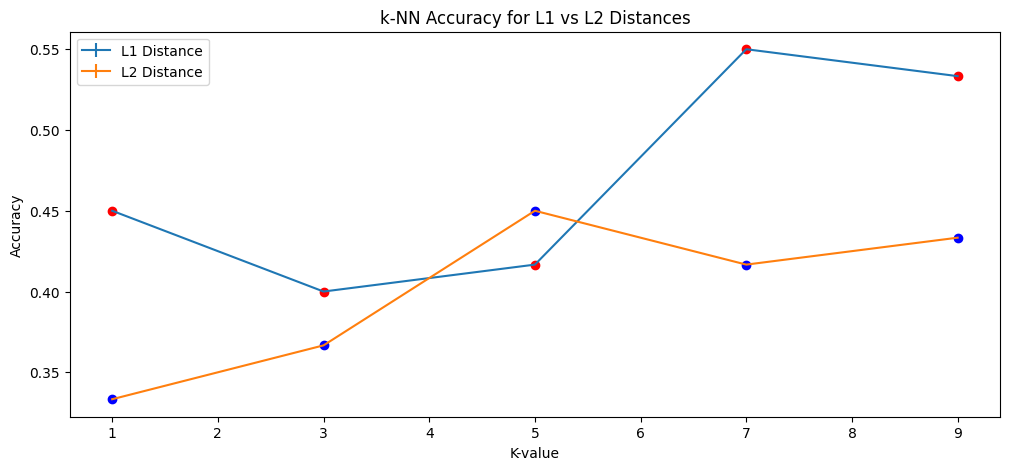

In [ ]:
mean_l1 = [np.mean(fold_metrics_l1[k]) for k in k_values]
std_l1  = [np.std(fold_metrics_l1[k]) for k in k_values]

mean_l2 = [np.mean(fold_metrics_l2[k]) for k in k_values]
std_l2  = [np.std(fold_metrics_l2[k]) for k in k_values]

plt.figure(figsize=(12, 5))
plt.errorbar(k_values, mean_l1, yerr=std_l1, label="L1 Distance")
plt.errorbar(k_values, mean_l2, yerr=std_l2, label="L2 Distance")

plt.scatter(k_values, mean_l1, color="red")
plt.scatter(k_values, mean_l2, color="blue")

plt.xlabel("K-value")
plt.ylabel("Accuracy")
plt.title("k-NN Accuracy for L1 vs L2 Distances")
plt.legend()
plt.show()

# Step 9: Top 5 Visual Predictions on tested image


Top 5 Predictions (L1 Distance):
1. panda (distance=0)
2. cat (distance=106674)
3. panda (distance=106813)
4. cat (distance=107726)
5. cat (distance=109434)


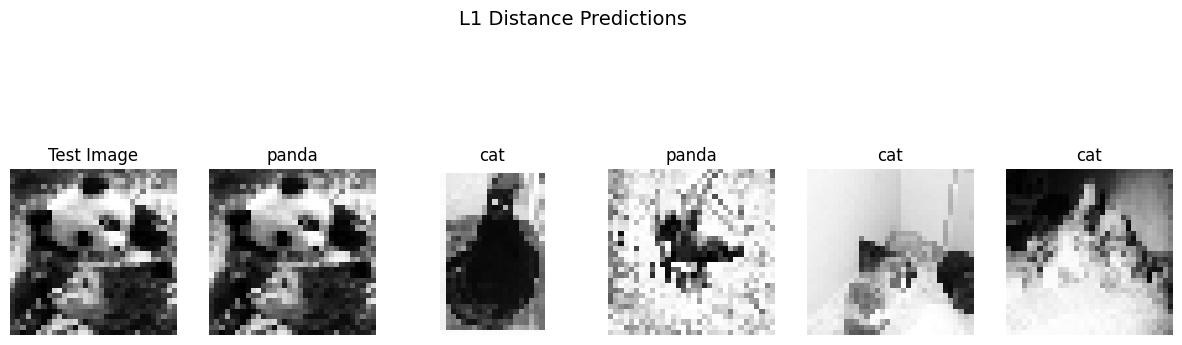


Top 5 Predictions (L2 Distance):
1. panda (distance=0.00)
2. panda (distance=316.55)
3. dog (distance=317.36)
4. panda (distance=317.97)
5. cat (distance=318.47)


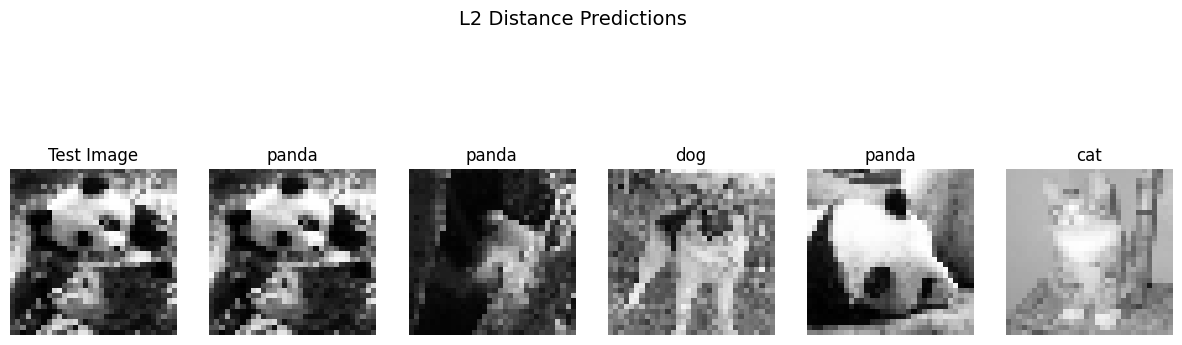

In [ ]:
test_image = TRAIN_DATA[0][0]

print("\nTop 5 Predictions (L1 Distance):")
l1_preds = []

for train_image, label in TRAIN_DATA:
    dist = l1_dist(test_image, train_image)
    l1_preds.append((dist, label, train_image))

l1_preds.sort(key=lambda x: x[0])


plt.figure(figsize=(15, 5))
plt.suptitle("L1 Distance Predictions", fontsize=14)


plt.subplot(1, 6, 1)
plt.imshow(cv.cvtColor(test_image, cv.COLOR_BGR2RGB))
plt.title("Test Image")
plt.axis("off")


for i in range(5):
    dist, lab, img = l1_preds[i]


    print(f"{i+1}. {CATEGORIES[lab]} (distance={dist})")

    plt.subplot(1, 6, i+2)
    plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))


    plt.title(f"{CATEGORIES[lab]}")
    plt.axis("off")

plt.show()

print("\nTop 5 Predictions (L2 Distance):")
l2_preds = []


for train_image, label in TRAIN_DATA:
    dist = l2_dist(test_image, train_image)
    l2_preds.append((dist, label, train_image))

l2_preds.sort(key=lambda x: x[0])


plt.figure(figsize=(15, 5))
plt.suptitle("L2 Distance Predictions", fontsize=14)


plt.subplot(1, 6, 1)
plt.imshow(cv.cvtColor(test_image, cv.COLOR_BGR2RGB))
plt.title("Test Image")
plt.axis("off")


for i in range(5):
    dist, lab, img = l2_preds[i]


    print(f"{i+1}. {CATEGORIES[lab]} (distance={dist:.2f})")

    plt.subplot(1, 6, i+2)
    plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))


    plt.title(f"{CATEGORIES[lab]}")
    plt.axis("off")

plt.show()